# General setup

In [1]:
import os, sys
import time
import re
from glob import glob
import itertools

import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import h5py
import csv

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Basic utilities

In [3]:
start_time = None

def start_timer():
    global start_time
    if device == 'cuda':
        torch.cuda.synchronize()
    start_time = time.time()

def end_timer_and_print():
    if device == 'cuda':
        torch.cuda.synchronize()
    end_time = time.time()
    print("\nTotal execution time {:.3f} sec".format(end_time - start_time))

In [4]:
def plot_images(img_list, num=6, size=12):
    if isinstance(img_list, tuple):
        img_list = list(img_list)
    elif isinstance(img_list, (np.ndarray, torch.Tensor)):
        img_list = [img_list]
    else:
        raise Exception("input must be ndarray or sequence or list of ndarrays")
        
    for i in range(len(img_list)):
        if isinstance(img_list[i], torch.Tensor):
            img_list[i] = img_list[i].cpu().numpy()
            
        depth = img_list[i].ndim
        if depth == 4:
            continue
        elif depth == 3:
            img_list[i] = np.expand_dims(img_list[i], 0)
        elif depth == 2:
            img_list[i] = np.expand_dims(img_list[i], (0,1))
        else:
            raise Exception("image arrays must have depth between 2 and 4, inclusive")
            
    lengths = [imgs.shape[0] for imgs in img_list]
    if lengths.count(lengths[0]) != len(lengths):
        raise Exception("image arrays must have the same first dimension size")
    if num == -1 or num > lengths[0]:
        num = lengths[0]
    num_list = len(img_list)
    
    if num == 1:
        plt.figure(figsize=(size, size/num_list))
        for i, img in enumerate(img_list):
            plt.subplot(1, num_list, i+1)
            plt.imshow(img[0, 0], cmap='gray_r')
            plt.axis('off')
    else:
        plt.figure(figsize=(size, size*num_list/num))
        for i, imgs in enumerate(img_list):
            for j, img in enumerate(imgs):
                if j >= num: break
                plt.subplot(num_list, num, num*i+j+1)
                plt.imshow(img[0], cmap='gray_r')
                plt.axis('off')
    
    plt.show()

# Setup

## Defining models

In [5]:
CA3_size = 2048
EC_size = 1024
sparse_sp = 0.02
dense_sp = 0.2

In [6]:
def step(x, x0):
    return (x > x0).float()

class STEFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x):
        return step(x, 0.)

    @staticmethod
    def backward(ctx, grad_output):
        return F.hardtanh(grad_output)

class Binarize(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return STEFunction.apply(x)

In [10]:
# Autoencoder between images and EC
class Autoencoder(nn.Module):
    def __init__(self, hidden_size=128):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, EC_size),
            nn.BatchNorm1d(EC_size),
            Binarize()
        )
        self.decoder = nn.Sequential(
            nn.Linear(EC_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 28*28),
            nn.Sigmoid(),
            nn.Unflatten(-1, (1, 28, 28))
        )
        
    def forward(self, x):
        features = self.encoder(x)
        x = self.decoder(features)
        return x, features

In [11]:
# Feedforward visualization pathway from MF and PP patterns to EC
class Feedforward(nn.Module):
    def __init__(self, hidden_size=2*CA3_size):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.feedforward = nn.Sequential(
            nn.Linear(CA3_size, self.hidden_size),
            nn.BatchNorm1d(self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, EC_size),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.feedforward(x)

class FeedforwardDataset(Dataset):
    def __init__(self, X, Y, transform=None):
        self.X = X
        self.Y = Y
        self.transform = transform
        if len(X) != len(Y):
            raise Exception("input and output patterns must have same length")

    def __len__(self):
        return len(self.X)
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        X_sample = self.X[idx]
        Y_sample = self.Y[idx]
        
        if self.transform:
            X_sample = self.transform(X_sample)
            Y_sample = self.transform(Y_sample)
        
        return (X_sample, Y_sample)

## Loading trained models

In [12]:
AE_data = torch.load(f"out/pathways/AE.pt", map_location=torch.device(device))
AE_model = Autoencoder(hidden_size=128).to(device)
AE_model.load_state_dict(AE_data['model_state_dict'])

true_imgs = torch.cat(AE_data['X_by_class'])
true_categories = torch.stack(AE_data['X_concepts'])

FF_data = torch.load(f"out/pathways/FF.pt", map_location=torch.device(device))
FF_model = Feedforward(hidden_size=2*CA3_size).to(device)
FF_model.load_state_dict(FF_data['model_state_dict'])

<All keys matched successfully>

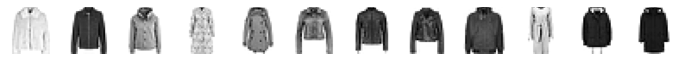

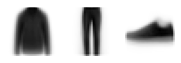

In [13]:
plot_images(true_imgs, num=12)
plot_images(true_categories, size=3)

## Loading Hopfield data

In [14]:
def read_binary_patterns(pattern_file, pattern_size=CA3_size):
    binfile = open(pattern_file, 'rb')
    bindata = np.fromfile(binfile, dtype=np.uint8)
    binfile.close()
    patterns = torch.as_tensor(np.unpackbits(bindata).reshape((-1, pattern_size)),
                               dtype=torch.float)
    return patterns

In [16]:
pattern_dir = "out/pathways/N2048-p3-s512-a02-2"
dense_patterns = read_binary_patterns(f"{pattern_dir}/x_dense.dat")

In [41]:
def get_fileroots(dataset_dir):
    files = sorted(glob(f"{dataset_dir}/*_params.txt"))
    return [file.split('_params.txt')[0] for file in files]

def get_params(fileroot):
    params = {}
    with open(f"{fileroot}_params.txt", 'r') as file:
        reader = csv.reader(file, delimiter='=')
        for line in reader:
            if line:
                params[line[0].strip()] = line[1].strip()
    
    return params

In [18]:
# Returns cue and target information
def get_info(fileroot):
    params = get_params(fileroot)
    num_examples = params['s']
    
    pattern_dict = {'0': 'sparse', '1': 'dense', '2': 'cat', '3': 'both'}
    cue_type = pattern_dict[params['cue_type']]
    target_type = pattern_dict[params['target_type']]
    
    return (cue_type, target_type, num_examples)

def get_category_ids(fileroot):
    params = get_params(fileroot)
    num_examples = int(params['s'])
    cue_inds = np.genfromtxt(f"{fileroot}_qcue.txt", dtype='int')
    
    return cue_inds // num_examples

In [20]:
# True target images for each Hopfield network cue
def get_target_images(fileroot):
    params = get_params(fileroot)
    num_categories = int(params['p'])
    num_examples = int(params['s'])
    max_examples = int(re.search('-s\d+', params['X_dir']).group(0)[2:])
    
    cue_inds = np.genfromtxt(f"{fileroot}_qcue.txt", dtype='int')
    mu_inds = np.genfromtxt(f"{fileroot}_qmu.txt", dtype='int')
    nu_inds = np.genfromtxt(f"{fileroot}_qnu.txt", dtype='int')
    
    storage_inds = np.hstack([mu*max_examples + nu_inds for mu in mu_inds])
    if 'target_type' in params and params['target_type'] == '2':
        target_inds = cue_inds // num_examples
        target_imgs = true_categories[target_inds]
    else:
        target_inds = storage_inds[cue_inds]
        target_imgs = true_imgs[target_inds]
    
    return target_imgs.cpu().numpy()

In [21]:
# Read in classic overlaps
def get_overlaps(fileroot):
    overlaps = np.genfromtxt(f"{fileroot}_mclassic.txt")[:,-1]
    
    return overlaps

In [22]:
# Images encoded by the Hopfield network
def get_hopfield_images(fileroot):
    params = get_params(fileroot)
    num_cues = int(params['n_cue'])
    activities = read_binary_patterns(f"{fileroot}_s.dat")
    
    FF_model.eval()
    AE_model.eval()
    with torch.no_grad():
        # Binarize FF outputs before presenting to AE
        imgs = AE_model.decoder(step(FF_model(
            activities.to(device)
        ), 0.5))
        imgs = imgs.view((num_cues, -1, *imgs.shape[-3:]))
        
    return imgs.cpu().numpy()

# Images encoded by the Hopfield network with all neurons flipped from active and inactive.
# The inversions of dense patterns can also be equivalent stable Hopfield states.
def get_reversed_images(fileroot):
    params = get_params(fileroot)
    num_cues = int(params['n_cue'])
    activities = read_binary_patterns(f"{fileroot}_s.dat")
    
    FF_model.eval()
    AE_model.eval()
    with torch.no_grad():
        # Binarize FF outputs before presenting to AE
        imgs = AE_model.decoder(step(FF_model(
            1.-activities.to(device)
        ), 0.5))
        imgs = imgs.view((num_cues, -1, *imgs.shape[-3:]))
        
    return imgs.cpu().numpy()

In [23]:
# Get fileroots of simulations PP concept targets to also perform PP example analysis
def get_dense_fileroots(dataset_dir):
    files = sorted(glob(f"{dataset_dir}/out/?c*_params.txt"))
    return [file.split('_params.txt')[0] for file in files]

# Classic overlap
def calculate_overlap(activity, pattern, sp, pattern_size=CA3_size):
    overlap = np.dot(activity, pattern-sp)
    overlap /= pattern_size * sp * (1.-sp)

    return overlap

# True PP example patterns
pattern_dir = "out/pathways/N2048-p3-s512-a02-2"
dense_patterns = read_binary_patterns(f"{pattern_dir}/x_dense.dat")

# Overlaps with PP examples, which are retrieved at the same theta as PP concepts.
def get_dense_overlaps(fileroot):
    params = get_params(fileroot)
    num_cues = int(params['n_cue'])
    num_categories = int(params['p'])
    num_examples = int(params['s'])
    max_examples = int(re.search('-s\d+', params['X_dir']).group(0)[2:])
    
    cue_inds = np.genfromtxt(f"{fileroot}_qcue.txt", dtype='int')
    mu_inds = np.genfromtxt(f"{fileroot}_qmu.txt", dtype='int')
    nu_inds = np.genfromtxt(f"{fileroot}_qnu.txt", dtype='int')
    storage_inds = np.hstack([mu*max_examples + nu_inds for mu in mu_inds])
    
    activities = read_binary_patterns(f"{fileroot}_s.dat")
    cue_storage_inds = np.repeat([storage_inds[idx] for idx in cue_inds],
                                 len(activities) // num_cues) 
    
    overlaps = [calculate_overlap(activity, dense_patterns[idx], dense_sp)
                for activity, idx in zip(activities, cue_storage_inds)]
    
    overlaps = np.array(overlaps).reshape(num_cues, -1)[:,-1]
    
    return overlaps

# Results

## Parameter sweep from `2b_sweep.sh`

In [42]:
dataset_dir = 'sweep'
fileroots = get_fileroots('out/'+dataset_dir)

info = [get_info(root) for root in fileroots]
category_ids = [get_category_ids(root) for root in fileroots]
overlaps = [get_overlaps(root) for root in fileroots]
target_imgs = [get_target_images(root) for root in fileroots]
hopfield_imgs = [get_hopfield_images(root) for root in fileroots]
reversed_imgs = [get_reversed_images(root) for root in fileroots]

In [43]:
# While overlaps with PP concepts were computed and saved during the Hopfield simulations,
# overlaps with PP examples are computed here.
dense_info = [get_info(root) for root in fileroots]
dense_overlaps = [get_dense_overlaps(root) for root in fileroots]

In [44]:
# Saving data for further analysis
h5file = h5py.File(f'out/visualization/{dataset_dir}.h5', 'w')

h5file.create_dataset("info", data=info)
h5file.create_dataset("category_ids", data=category_ids)
h5file.create_dataset("overlaps", data=overlaps)
h5file.create_dataset("target_imgs",
                      data=target_imgs, compression='gzip')
h5file.create_dataset("hopfield_imgs",
                      data=hopfield_imgs, compression='gzip')
h5file.create_dataset("reversed_imgs",
                      data=reversed_imgs, compression='gzip')

h5file.create_dataset("dense_info", data=dense_info)
h5file.create_dataset("dense_overlaps", data=dense_overlaps)

h5file.close()

('both', 'cat', '1')


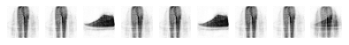



('both', 'cat', '3')


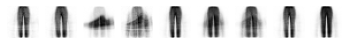



('both', 'cat', '10')


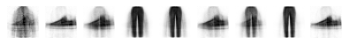



('both', 'cat', '30')


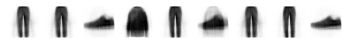



('both', 'cat', '100')


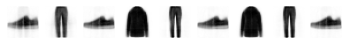



('both', 'sparse', '1')


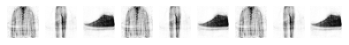



('both', 'sparse', '3')


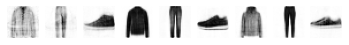



('both', 'sparse', '10')


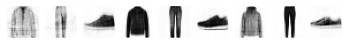



('both', 'sparse', '30')


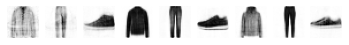



('both', 'sparse', '100')


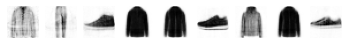



('dense', 'cat', '1')


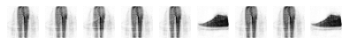



('dense', 'cat', '3')


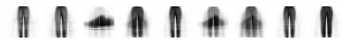



('dense', 'cat', '10')


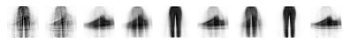



('dense', 'cat', '30')


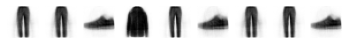



('dense', 'cat', '100')


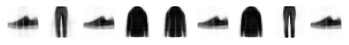



('dense', 'sparse', '1')


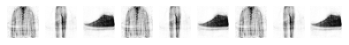



('dense', 'sparse', '3')


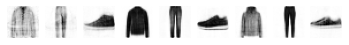



('dense', 'sparse', '10')


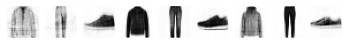



('dense', 'sparse', '30')


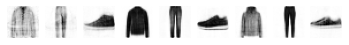



('dense', 'sparse', '100')


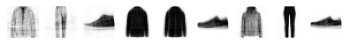



('sparse', 'cat', '1')


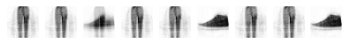



('sparse', 'cat', '3')


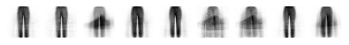



('sparse', 'cat', '10')


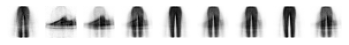



('sparse', 'cat', '30')


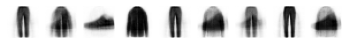



('sparse', 'cat', '100')


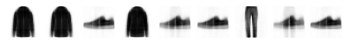



('sparse', 'sparse', '1')


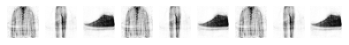



('sparse', 'sparse', '3')


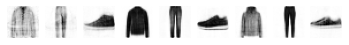



('sparse', 'sparse', '10')


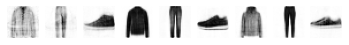



('sparse', 'sparse', '30')


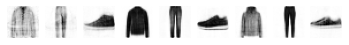



('sparse', 'sparse', '100')


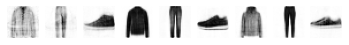

In [47]:
for hopfield, item in zip(hopfield_imgs, info):
    print(f"{item}")
    plot_images(hopfield[:,-1], num=9, size=6)
    if torch.cuda.is_available(): torch.cuda.synchronize()
    print(f"\n")

## Oscillating threshold from `2c_oscillation.sh`

In [68]:
dataset_dir = 'oscillation'
fileroots = get_fileroots('out/'+dataset_dir)

info = [os.path.basename(root) for root in fileroots]
category_ids = [get_category_ids(root) for root in fileroots]
hopfield_imgs = [get_hopfield_images(root) for root in fileroots]
target_imgs = [get_target_images(root) for root in fileroots]

In [69]:
# Saving data for further analysis
h5file = h5py.File(f'out/visualization/{dataset_dir}.h5', 'w')

h5file.create_dataset("info", data=info)
h5file.create_dataset("category_ids", data=category_ids)
h5file.create_dataset("hopfield_imgs",
                      data=hopfield_imgs, compression='gzip')
h5file.create_dataset("target_imgs",
                      data=target_imgs, compression='gzip')

h5file.close()

baseline


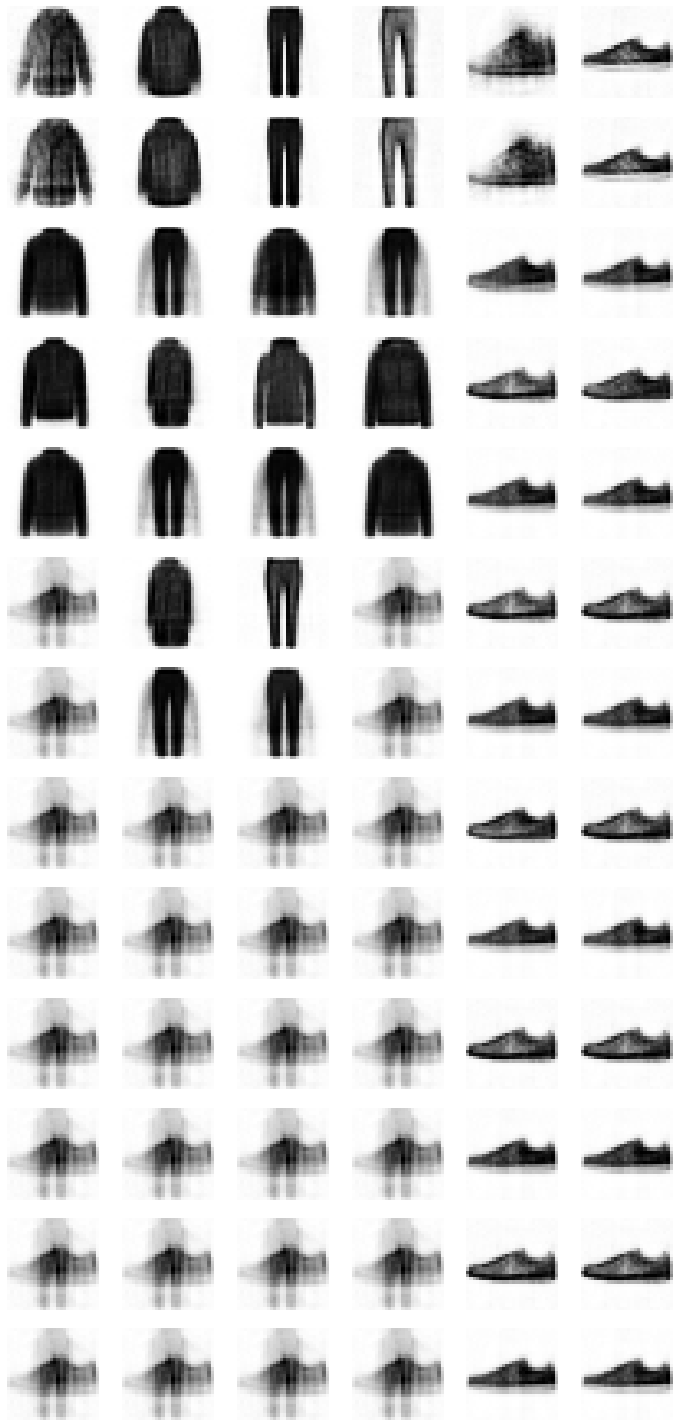

In [70]:
for hopfield, item in zip(hopfield_imgs, info):
    print(f"{item}")
    plot_images(
        tuple([hopfield[::5,t] for t in range(0, hopfield.shape[1], 20)]),
        num=-1)
    if torch.cuda.is_available(): torch.cuda.synchronize()
    print(f"\n")